<a href="https://colab.research.google.com/github/Turakulov/Python/blob/master/News_parsing%26clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [0]:
# import sys
# !{sys.executable} -m pip install pymorphy2

import requests # Загрузка новостей с сайта.
from bs4 import BeautifulSoup # Превращалка html в текст.
import re

import pandas as pd
pd.set_option('display.max_rows', 9999)

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
from sklearn.decomposition import PCA

from sklearn import preprocessing

import numpy as np
import nltk
nltk.download(['averaged_perceptron_tagger_ru', 'stopwords'])
stopwords = nltk.corpus.stopwords.words('russian')
#можно расширить список стоп-слов
stopwords.extend(['что', 'это', 'так', 'вот', 'быть', 'как', 'в', 'к', 'на'])

from tqdm import tqdm
import pymorphy2

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
plt.rcParams['figure.figsize'] = (12, 8)
 

In [0]:
# Если нужно посмотреть то можно запустить в колабе отсюда
# df2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/dataset_reduced.csv', encoding='utf-8')

In [0]:
df = pd.DataFrame(columns=['articles','category','url'], index = range(10000))

In [120]:
for x in range(999999, 990000, -1):
    h3s = BeautifulSoup(requests.get(f"https://iz.ru/{x}").text, "html.parser").find_all("div", {"id": "block-purple-content"})
    txts = ' '.join(re.findall("<p>(.*?)</p>", str(h3s)))
    txts = re.sub("<[/ai](.*?)>", "", txts)
    try:
        rub = ''.join([l.find_all("a")[0]['href'] for l in h3s])
        rub = rub.replace("/rubric/", "")
    except:
        rub = 'NaN'
    df.loc[x-990001].articles = txts
    df.loc[x-990001].category = rub
    df.loc[x-990001].url = "https://iz.ru/" + str(x)
df

articles  ...                   url
0     На Украине выздоровели восемь пациентов с коро...  ...  https://iz.ru/990001
1     Российские военные оперативно выполнили поруче...  ...  https://iz.ru/990002
2                                                        ...  https://iz.ru/990003
3                                                   NaN  ...                   NaN
4                                                   NaN  ...                   NaN
5                                                   NaN  ...                   NaN
6                                                   NaN  ...                   NaN
7                                                   NaN  ...                   NaN
8                                                   NaN  ...                   NaN
9                                                   NaN  ...                   NaN
10                                                  NaN  ...                   NaN
11                                                  NaN  ...                   NaN
12                                                  NaN  ...                   NaN
13                                                  NaN  ...                   NaN
14                                                  NaN  ...                   NaN
15                                                  NaN  ...                   NaN
16                                                  NaN  ...                   NaN
17                                                  NaN  ...                   NaN
18                                                  NaN  ...                   NaN
19                                                  NaN  ...                   NaN
20                                                  NaN  ...                   NaN
21                                                  NaN  ...                   NaN
22                                                  NaN  ...                   NaN
23                                                  NaN  ...                   NaN
24                                                  NaN  ...                   NaN
25                                                  NaN  ...                   NaN
26                                                  NaN  ...                   NaN
27                                                  NaN  ...                   NaN
28                                                  NaN  ...                   NaN
29                                                  NaN  ...                   NaN
30                                                  NaN  ...                   NaN
31                                                  NaN  ...                   NaN
32                                                  NaN  ...                   NaN
33                                                  NaN  ...                   NaN
34                                                  NaN  ...                   NaN
35                                                  NaN  ...                   NaN
36                                                  NaN  ...                   NaN
37                                                  NaN  ...                   NaN
38                                                  NaN  ...                   NaN
39                                                  NaN  ...                   NaN
40                                                  NaN  ...                   NaN
41                                                  NaN  ...                   NaN
42                                                  NaN  ...                   NaN
43                                                  NaN  ...                   NaN
44                                                  NaN  ...                   NaN
45                                                  NaN  ...                   NaN
46                                                  NaN  ...                   NaN
47                                                  NaN  ...   

In [0]:
df2 = df

In [0]:
df2 = df2.drop(df2[df2['articles'] == ""].index)
df2 = df2.drop(df2[df2['category'].str.contains('https', regex=False)].index)
df2 = df2.reset_index(drop=True)
df2

articles          category  \
0     На Украине выздоровели восемь пациентов с коро...               mir   
1     Российские военные оперативно выполнили поруче...            armiia   
2     Работа горнолыжного курорта «Большой Вудъявр» ...  novosti-kompanii   
3     Индийский столичный округ Дели, в состав котор...               mir   
4     Обычная ветка из леса, несколько рулонов скотч...           kultura   
5     «Николай Николаевич тяжело болел. Днем ему ста...       obshchestvo   
6     Кабинет министров Германии и правительства фед...               mir   
7     Правительство Испании продлит действие режима ...               mir   
8     Вспышка коронавируса SARS-CoV-2, вызывающего т...       obshchestvo   
9     Вода в озерах Тверской области достигла критич...            strana   
10    Испанский оперный певец Пласидо Доминго заявил...               mir   
11    Во Франции скончался первый врач, боровшийся с...               mir   
12    Чемпион UFC в легком весе Хабиб Нурмагомедов п...             sport   
13    С нарушением своих прав в 2019 году столкнулос...       obshchestvo   
14    Американский боец смешанного стиля UFC Тони Фе...             sport   
15    ЗРС С-400 «Триумф» на совместных учениях войск...            armiia   
16    Новый корпус Орловского облсуда открылся на Кр...            strana   
17    На церемонии официальной встречи форума «Росси...            armiia   
18    Российский нападающий клуба «Сент-Луис Блюз» В...             sport   
19    С 23 марта в Греции вводятся ограничения на ав...               mir   
20    Учения «Океанский щит – 2019» в Балтийском мор...            armiia   
21    Катер береговой охраны США (фото с борта круиз...               mir   
22                У бассейна круизного лайнера Princess               mir   
23    Минкультуры России рекомендовало кинотеатрам п...           kultura   
24              Вид с палубы круизного лайнера Princess               mir   
25    Губернаторы по согласованию с Минстроем России...       obshchestvo   
26    Военнослужащий российского центра по примирени...            armiia   
27    Испытания крылатой ракеты средней дальности ми...            armiia   
28    В Пензе официально определена приаэродромная т...            strana   
29    Распространение коронавируса повлияло на жизнь...               mir   
30    Днем в субботу, 21 марта, на Куйбышевском шосс...            strana   
31    Местный житель у афиши чемпионата мира по хокк...             sport   
32    Талисман чемпионата мира по хоккею – 2019 по х...             sport   
33    Баннер с изображением ежика Спайки, ставшего о...             sport   
34    Власти Великобритании рекомендовали лицам, под...               mir   
35    Власти Германии запретили собираться больше дв...               mir   
36    Сотрудник американского Агентства по оборонном...               mir   
37    Американский сенатор от Республиканской партии...               mir   
38    Канцлер Германии Ангела Меркель отправляется н...               mir   
39    Во Франции число подтвержденных случаев зараже...               mir   
40    На черноморском курорте в Одесской области заг...               mir   
41    За последний год российские заемщики заметно п...         ekonomika   
42    Сообщения о введении в Москву войск из-за коро...       obshchestvo   
43    Власти Израиля совместно с представителями иор...               mir   
44    Из-за пандемии коронавируса кабмин резко ускор...          politika   
45    «Деловая Россия» направила первому вице-премье...         ekonomika   
46    Общее количество заболевших COVID-19 в США сос...               mir   
47    Команда чемпиона Абсолютного бойцовского чемпи...             sport   
48    Белорусская авиакомпания «Белавиа» заявила о в...       obshchestvo   
49    За последний год российские заемщики заметно п...         ekonomika   
50    Премьер-министр Великобритании Борис Джонсон о...               mir   
51    Международный паралимпийский комитет 

In [0]:
print(df2.groupby('category')['url'].nunique())

category
/press-release        14
armiia               110
auto                 130
ekonomika            386
internet              36
kultura              145
mir                 1209
nauka                109
novosti-kompanii      24
obshchestvo         2087
politika             140
proisshestviia       222
sport                227
stil                   1
strana               892
turizm                40
Name: url, dtype: int64


In [86]:
df2 = df2.drop(df2[df2['category'] == "/press-release"].index)
df2 = df2.drop(df2[df2['category'] == "armiia"].index)
df2 = df2.drop(df2[df2['category'] == "auto"].index)
df2 = df2.drop(df2[df2['category'] == "internet"].index)
df2 = df2.drop(df2[df2['category'] == "kultura"].index)
df2 = df2.drop(df2[df2['category'] == "nauka"].index)
df2 = df2.drop(df2[df2['category'] == "novosti-kompanii"].index)
df2 = df2.drop(df2[df2['category'] == "obshchestvo"].index)
df2 = df2.drop(df2[df2['category'] == "politika"].index)
df2 = df2.drop(df2[df2['category'] == "proisshestviia"].index)
df2 = df2.drop(df2[df2['category'] == "stil"].index)
df2 = df2.drop(df2[df2['category'] == "strana"].index)
df2 = df2.drop(df2[df2['category'] == "turizm"].index)
df2 = df2.reset_index(drop=True)
print(df2.groupby('category')['articles'].nunique())

category
ekonomika     386
mir          1207
sport         227
Name: articles, dtype: int64


In [0]:
morph = pymorphy2.MorphAnalyzer()

In [0]:
imp_POS = ['ADJF', 'ADJS', 'NOUN', 'VERB', 'PRTF', 'PRTS', 'GRND']

def getMostFrequentWordsFiltered(text):
    
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        if pv[0].tag.POS in imp_POS and pv[0].normal_form != 'быть':
            words.append(pv[0].normal_form)
    text = ' '.join(words)
    
    counter=CountVectorizer(ngram_range=(1,2), stop_words=stopwords, token_pattern=r'[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+')
    res=counter.fit_transform([text])
    frq = sorted([(i, int(res[0][0,i])) for i in range(res[0].shape[1])], key = lambda x: x[1], reverse = True)[:5]
    vocab = {w:res[0,i] for w,i in counter.vocabulary_.items()}
    return [[w for w, n in counter.vocabulary_.items() if n==i][0] for i, f in frq], vocab

In [0]:
freqwords = []
vocabs = []
for i in tqdm(range(df2.shape[0])):
    fw, v = getMostFrequentWordsFiltered(df2.articles.iloc[i])
    freqwords.append(fw)
    vocabs.append(v)
    
df2['Vocabular'] = vocabs
df2['Freq Words'] = freqwords

100%|██████████████████████████████████████████████████████████████████████████████| 5768/5768 [14:54<00:00,  6.45it/s]


In [82]:
df2.head(10)

articles  ...                                         Freq Words
0  На Украине выздоровели восемь пациентов с коро...  ...  ['коронавирус', 'украина', 'человек', 'тысяча'...
1  Индийский столичный округ Дели, в состав котор...  ...         ['март', 'человек', 'весь', 'дели', 'год']
2  Кабинет министров Германии и правительства фед...  ...  ['человек', 'март', 'тысяча', 'фрг', 'агентство']
3  Правительство Испании продлит действие режима ...  ...  ['страна', 'испания', 'март', 'ограничение', '...
4  Испанский оперный певец Пласидо Доминго заявил...  ...  ['март', 'весь', 'вирус', 'коронавирус', 'чело...
5  Во Франции скончался первый врач, боровшийся с...  ...  ['врач', 'скончаться', 'тысяча', 'коронавирус'...
6  Чемпион UFC в легком весе Хабиб Нурмагомедов п...  ...  ['вес', 'лёгкое', 'лёгкое вес', 'чемпион', 'че...
7  Американский боец смешанного стиля UFC Тони Фе...  ...  ['американский', 'американский боец', 'боец', ...
8  Российский нападающий клуба «Сент-Луис Блюз» В...  ...  ['кубок', 'тарасенко', 'серия', 'сказать', 'ко...
9  С 23 марта в Греции вводятся ограничения на ав...  ...  ['март', 'греция', 'коронавирус', 'воскресение...

[10 rows x 5 columns]

In [0]:
def normalizePymorphy2(text):
    tokens = re.findall('[A-Za-zА-Яа-яЁё]+\-[A-Za-zА-Яа-яЁё]+|[A-Za-zА-Яа-яЁё]+', text)
    words = []
    for t in tokens:
        pv = morph.parse(t)
        words.append(pv[0].normal_form)
    return words

In [0]:
tfCounter = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords)
tfres = tfCounter.fit_transform([' '.join(normalizePymorphy2(n)) for n in df2.articles] )

In [29]:
print(tfres.shape)

(1822, 142683)


In [0]:
freqwords = []
for i in tqdm(range(df2.shape[0])):

    tfs = [(k,tfres[i][0, tfCounter.vocabulary_.get(k)]) for k in df2.Vocabular.iloc[i] 
         if k in tfCounter.vocabulary_.keys()]
    fw = [w for w, f in sorted(tfs, key = lambda x: x[1], reverse = True)[:5]]
    freqwords.append(fw)
    
df2['Freq Words TFIDF'] = freqwords

100%|██████████████████████████████████████████████████████████████████████████████| 5768/5768 [03:51<00:00, 24.87it/s]


In [80]:
df2.head(10)

articles  ...                                   Freq Words TFIDF
0  На Украине выздоровели восемь пациентов с коро...  ...  ['украина', 'украина выздороветь', 'центр', 'п...
1  Индийский столичный округ Дели, в состав котор...  ...  ['дели', 'частное', 'работать', 'арвинд', 'кед...
2  Кабинет министров Германии и правительства фед...  ...  ['фрг', 'меркель', 'общефедеральный', 'земеля ...
3  Правительство Испании продлит действие режима ...  ...  ['испания', 'санчёс', 'правительство испания',...
4  Испанский оперный певец Пласидо Доминго заявил...  ...  ['оперный певец', 'доминго', 'оперный', 'певец...
5  Во Франции скончался первый врач, боровшийся с...  ...  ['верана', 'смерть врач', 'врач', 'компьенить'...
6  Чемпион UFC в легком весе Хабиб Нурмагомедов п...  ...  ['лёгкое вес', 'вес', 'чемпион', 'лёгкое', 'ну...
7  Американский боец смешанного стиля UFC Тони Фе...  ...  ['петтис', 'фергюсон праздновать', 'победа энт...
8  Российский нападающий клуба «Сент-Луис Блюз» В...  ...  ['тарасенко', 'кубок', 'кубок стэнли', 'стэнли...
9  С 23 марта в Греции вводятся ограничения на ав...  ...  ['греция', 'мицотакиснуть', 'март греция', 'гр...

[10 rows x 6 columns]

In [57]:
df2 = df2.drop(['url'], axis=1)
df2 = df2.drop(['Vocabular'], axis=1)
df2 = df2.drop(['Freq Words'], axis=1)

le = preprocessing.LabelEncoder()

df2['category'] = le.fit_transform(df2['category'])

df2.head(10)

articles  ...                                   Freq Words TFIDF
0  На Украине выздоровели восемь пациентов с коро...  ...  ['украина', 'украина выздороветь', 'центр', 'п...
1  Индийский столичный округ Дели, в состав котор...  ...  ['дели', 'частное', 'работать', 'арвинд', 'кед...
2  Кабинет министров Германии и правительства фед...  ...  ['фрг', 'меркель', 'общефедеральный', 'земеля ...
3  Правительство Испании продлит действие режима ...  ...  ['испания', 'санчёс', 'правительство испания',...
4  Испанский оперный певец Пласидо Доминго заявил...  ...  ['оперный певец', 'доминго', 'оперный', 'певец...
5  Во Франции скончался первый врач, боровшийся с...  ...  ['верана', 'смерть врач', 'врач', 'компьенить'...
6  Чемпион UFC в легком весе Хабиб Нурмагомедов п...  ...  ['лёгкое вес', 'вес', 'чемпион', 'лёгкое', 'ну...
7  Американский боец смешанного стиля UFC Тони Фе...  ...  ['петтис', 'фергюсон праздновать', 'победа энт...
8  Российский нападающий клуба «Сент-Луис Блюз» В...  ...  ['тарасенко', 'кубок', 'кубок стэнли', 'стэнли...
9  С 23 марта в Греции вводятся ограничения на ав...  ...  ['греция', 'мицотакиснуть', 'март греция', 'гр...

[10 rows x 3 columns]

In [0]:
def optimal_cluster_elbow_method(matrix_data,max_clusters_check):
    Sum_of_squared_distances=[]
    K = range(1,max_clusters_check)
    for k  in K:
        km=KMeans(n_clusters=k)
        km=km.fit(matrix_data)
        Sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, Sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

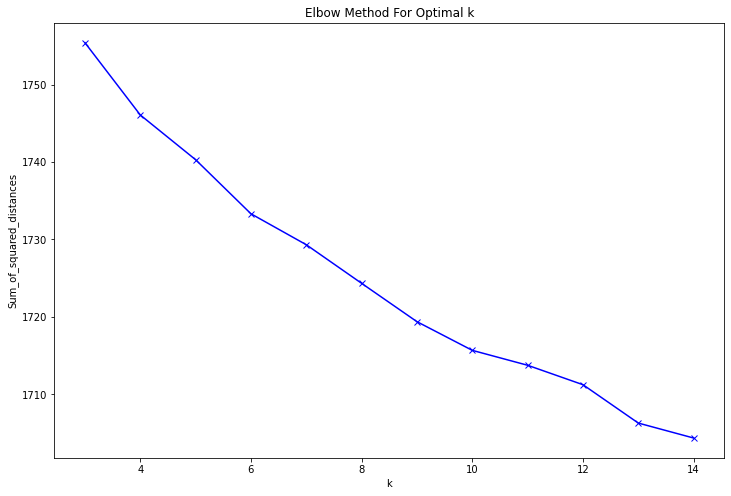

In [32]:
optimal_cluster_elbow_method(tfres,15)

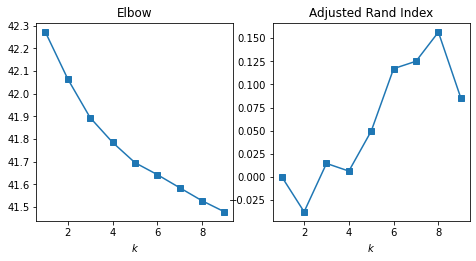

In [49]:
crit = []
ari = []

for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=1).fit(tfres)
    crit.append(np.sqrt(kmeans.inertia_))
    ari.append(adjusted_rand_score(df3['category'], kmeans.labels_))

ax1 = plt.subplot(234)
ax1.plot(range(1,10), crit, marker='s')
ax1.set_xlabel('$k$')
ax1.set_title('Elbow')

ax2 = plt.subplot(235)
ax2.plot(range(1,10), ari, marker='s')
ax2.set_xlabel('$k$')
ax2.set_title('Adjusted Rand Index')

plt.show()

In [0]:
kmeans1 = KMeans(n_clusters=3, random_state=1).fit(tfres)
kmeans1.cluster_centers_

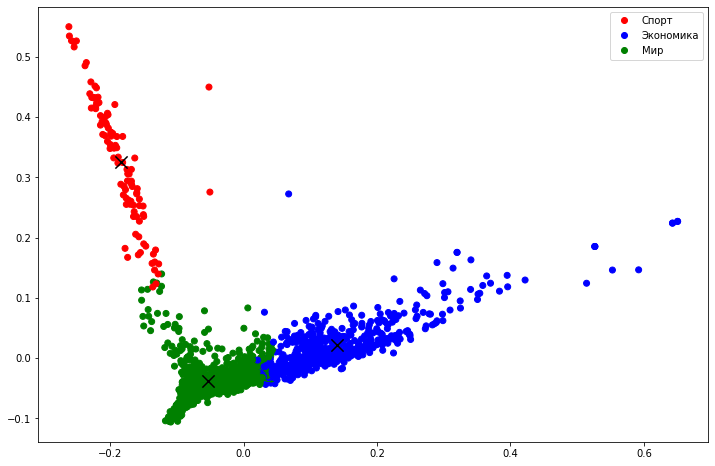

In [107]:
# Уменьшим размерность до 2D
pca = PCA(n_components=2, random_state=1)
reduced_features = pca.fit_transform(tfres.toarray())

# Уменьшим центры кластеров до 2D
reduced_cluster_centers = pca.transform(kmeans1.cluster_centers_)

classes = ['Спорт', 'Экономика', 'Мир']
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(reduced_features[:,0], reduced_features[:,1], c=kmeans1.predict(tfres), cmap=colours)
plt.scatter(reduced_cluster_centers[:, 0], reduced_cluster_centers[:,1], marker='x', s=150, c='black')
plt.legend(handles=scatter.legend_elements()[0], labels=classes)

In [0]:
import umap

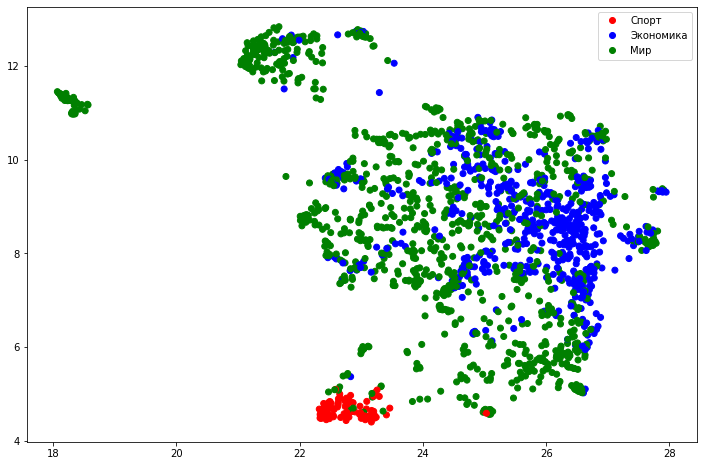

In [122]:
show_reduced = umap.UMAP(n_neighbors=30).fit_transform(tfres)

classes = ['Спорт', 'Экономика', 'Мир']
colours = ListedColormap(['r','b','g'])
scatter = plt.scatter(show_reduced[:,0], show_reduced[:,1], c=kmeans1.predict(tfres), cmap=colours)
plt.legend(handles=scatter.legend_elements()[0], labels=classes)